# 🚀 Spark Tune - Enhanced Features Demo

This notebook demonstrates all the new features added to Spark Tune:

1. **Data Quality Checking** - PySpark-native quality analysis
2. **YData Profiling** - Comprehensive data profiling
3. **Time Series Detection** - Automatic temporal structure detection
4. **Enhanced Preprocessing** - Missing values, outliers, scaling, rare categories
5. **Baseline Models** - Simple model comparison
6. **LightAutoML** - Automated machine learning
7. **Model Comparison** - Impact analysis framework

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

## 1. Initialize Spark and Load Data

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Spark Tune Enhanced Demo") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/18 01:19:38 WARN Utils: Your hostname, Yadvendras-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.6 instead (on interface en0)
26/01/18 01:19:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/18 01:19:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


In [ ]:
from backend.core.utils import process_col_names

# Load the bank marketing dataset
df = spark.read.options(
    header=True,
    inferSchema='True',
    delimiter=','
).csv("data/bank-additional-full.csv")

# Process column names
df = process_col_names(df)

print(f"Dataset shape: {df.count():,} rows x {len(df.columns)} columns")
df.printSchema()

Dataset shape: 41,188 rows x 21 columns
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



---
## 2. 📋 Data Quality Checking (NEW)

The `DataQualityChecker` performs PySpark-native quality analysis without converting to Pandas,
making it suitable for very large datasets.

In [ ]:
from backend.core.profiling.data_quality import DataQualityChecker

# Run data quality checks
quality_checker = DataQualityChecker(df)
quality_report = quality_checker.run_all_checks()

print("=" * 60)
print("DATA QUALITY REPORT")
print("=" * 60)
print(f"\n📊 Quality Score: {quality_report.quality_score}/100")
print(f"📈 Row Count: {quality_report.row_count:,}")
print(f"📋 Column Count: {quality_report.column_count}")
print(f"🔄 Duplicate Rows: {quality_report.duplicate_count:,}")

DATA QUALITY REPORT

📊 Quality Score: 100.0/100
📈 Row Count: 41,188
📋 Column Count: 21
🔄 Duplicate Rows: 12


In [5]:
# Display quality issues
print("\n⚠️ DATA QUALITY ISSUES:")
print("-" * 40)
if quality_report.issues:
    for issue in quality_report.issues[:10]:
        severity_icon = "🔴" if issue['severity'] == 'high' else "🟡" if issue['severity'] == 'medium' else "🟢"
        print(f"{severity_icon} [{issue['severity'].upper()}] {issue['column']}: {issue['issue']}")
else:
    print("✅ No major quality issues detected!")


⚠️ DATA QUALITY ISSUES:
----------------------------------------
🟢 [LOW] duration: Highly skewed distribution (skewness: 3.26)
🟢 [LOW] campaign: Highly skewed distribution (skewness: 4.76)
🟢 [LOW] pdays: Highly skewed distribution (skewness: -4.92)
🟢 [LOW] previous: Highly skewed distribution (skewness: 3.83)


In [6]:
# Display recommendations
print("\n💡 PREPROCESSING RECOMMENDATIONS:")
print("-" * 40)
if quality_report.recommendations:
    for rec in quality_report.recommendations[:10]:
        priority_icon = "🔴" if rec['priority'] == 'high' else "🟡" if rec['priority'] == 'medium' else "🟢"
        print(f"{priority_icon} [{rec['priority'].upper()}] {rec['column']}: {rec['action']}")
else:
    print("✅ No preprocessing recommendations needed!")


💡 PREPROCESSING RECOMMENDATIONS:
----------------------------------------
🟢 [LOW] duration: Apply log or Box-Cox transformation
🟢 [LOW] campaign: Apply log or Box-Cox transformation
🟢 [LOW] pdays: Apply log or Box-Cox transformation
🟢 [LOW] previous: Apply log or Box-Cox transformation


In [7]:
# Detect outliers
print("\n📊 OUTLIER DETECTION (IQR Method):")
print("-" * 40)
outliers = quality_checker.detect_outliers(method='iqr', threshold=1.5)

for col, stats in outliers.items():
    if stats['outlier_pct'] > 0:
        print(f"  {col}: {stats['outlier_count']:,} outliers ({stats['outlier_pct']:.2f}%)")
        print(f"    Bounds: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")


📊 OUTLIER DETECTION (IQR Method):
----------------------------------------
  age: 469 outliers (1.14%)
    Bounds: [9.50, 69.50]
  duration: 2,963 outliers (7.19%)
    Bounds: [-223.50, 644.50]
  campaign: 2,406 outliers (5.84%)
    Bounds: [-2.00, 6.00]
  pdays: 1,515 outliers (3.68%)
    Bounds: [999.00, 999.00]
  previous: 5,625 outliers (13.66%)
    Bounds: [0.00, 0.00]
  cons_conf_idx: 447 outliers (1.09%)
    Bounds: [-52.15, -26.95]


---
## 3. 📊 YData Profiling (NEW)

The `DataProfiler` generates comprehensive data profiles using ydata-profiling,
with automatic sampling for large datasets.

In [8]:
from backend.core.profiling.ydata_profiler import DataProfiler, quick_profile

# Quick profile (faster, minimal report)
print("Generating quick profile...")
quick_stats = quick_profile(df, max_rows=10000)

print("\n📈 QUICK PROFILE SUMMARY:")
print("-" * 40)
summary = quick_stats['summary']
print(f"  Rows: {summary.get('n_rows', 0):,}")
print(f"  Columns: {summary.get('n_columns', 0)}")
print(f"  Missing Cells: {summary.get('missing_cells_pct', 0):.2f}%")
print(f"  Duplicate Rows: {summary.get('duplicate_rows_pct', 0):.2f}%")

Generating quick profile...


Dataset has 41,188 rows, exceeding max_rows=10,000. Sampling 10,000 rows.
Render HTML: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


📈 QUICK PROFILE SUMMARY:
----------------------------------------
  Rows: 10,016
  Columns: 21
  Missing Cells: 0.00%
  Duplicate Rows: 0.00%


In [9]:
# Display alerts
print("\n⚠️ DATA ALERTS:")
print("-" * 40)
if quick_stats['alerts']:
    for alert in quick_stats['alerts'][:10]:
        print(f"  - {alert['column']}: {alert['type']}")
else:
    print("  ✅ No alerts!")


⚠️ DATA ALERTS:
----------------------------------------
  - previous: ZEROS


In [10]:
# Display profiling recommendations
print("\n💡 PROFILING RECOMMENDATIONS:")
print("-" * 40)
if quick_stats['recommendations']:
    for rec in quick_stats['recommendations'][:10]:
        priority_icon = "🔴" if rec['priority'] == 'high' else "🟡" if rec['priority'] == 'medium' else "🟢"
        print(f"{priority_icon} {rec['column']}: {rec['action']}")


💡 PROFILING RECOMMENDATIONS:
----------------------------------------
🟡 duration: Consider log transformation or Box-Cox
🟡 campaign: Consider log transformation or Box-Cox
🟡 pdays: Consider log transformation or Box-Cox
🟡 previous: Consider log transformation or Box-Cox


---
## 4. 🎯 Problem Definition & Schema Validation

In [ ]:
from backend.core.discovery import Problem, SchemaChecks

# Define the ML problem
problem = Problem(
    target="y",
    type="classification",
    desired_result="yes"
)

print(f"Problem Type: {problem.type}")
print(f"Target Column: {problem.target}")
print(f"Desired Result: {problem.desired_result}")

Problem Type: classification
Target Column: y
Desired Result: yes


In [12]:
# Validate schema
schema_checker = SchemaChecks(dataframe=df, problem=problem)
schema_info = schema_checker.check()

print(f"\n📋 SCHEMA SUMMARY:")
print(f"  Categorical columns: {len(schema_info['categorical'])}")
print(f"  Numerical columns: {len(schema_info['numerical'])}")
print(f"  Boolean columns: {len(schema_info['boolean'])}")

2
string ['string', 'char', 'varchar', 'bool', 'int']
4

📋 SCHEMA SUMMARY:
  Categorical columns: 11
  Numerical columns: 10
  Boolean columns: 0


---
## 5. ⏱️ Time Series Detection (NEW)

The `detect_time_series_structure` function automatically identifies temporal patterns
and recommends appropriate time-series features.

In [ ]:
from backend.core.utils.time_series_detector import detect_time_series_structure, TimeSeriesFrequency

# Detect time-series structure
ts_info = detect_time_series_structure(df, schema_checker)

print("\n⏱️ TIME SERIES DETECTION RESULTS:")
print("-" * 40)
print(f"  Is Time Series: {ts_info.is_time_series}")
print(f"  Time Column: {ts_info.time_column or 'N/A'}")
print(f"  Frequency: {ts_info.frequency.value if ts_info.frequency else 'N/A'}")
print(f"  Entity Columns: {ts_info.entity_columns or 'N/A'}")

if ts_info.warnings:
    print("\n⚠️ Warnings:")
    for warning in ts_info.warnings:
        print(f"    - {warning}")

if ts_info.recommended_features:
    print("\n💡 Recommended Time-Series Features:")
    for feature in ts_info.recommended_features:
        print(f"    - {feature}")


⏱️ TIME SERIES DETECTION RESULTS:
----------------------------------------
  Is Time Series: False
  Time Column: N/A
  Frequency: unknown
  Entity Columns: N/A

⚠️ Warnings:
    - No datetime columns detected in dataset


---
## 6. 🔧 Enhanced Preprocessing (NEW)

The `EnhancedPreprocessor` provides feature-engine inspired transformations:
- Missing value imputation (mean, median, mode, constant)
- Outlier handling (IQR cap/remove, Z-score cap/remove)
- Feature scaling (standard, minmax, robust)
- Rare category grouping

In [ ]:
from backend.core.features.preprocessing_enhanced import (
    EnhancedPreprocessor, PreprocessingConfig,
    ImputationStrategy, OutlierStrategy, ScalingStrategy
)

# Configure preprocessing
config = PreprocessingConfig(
    imputation_strategy=ImputationStrategy.MEDIAN,
    outlier_strategy=OutlierStrategy.IQR_CAP,
    outlier_threshold=1.5,
    scaling_strategy=ScalingStrategy.ROBUST,
    rare_category_threshold=0.01,  # 1%
    rare_category_replacement="RARE"
)

print("📋 PREPROCESSING CONFIGURATION:")
print(f"  Imputation: {config.imputation_strategy.value}")
print(f"  Outlier Handling: {config.outlier_strategy.value if config.outlier_strategy else 'None'}")
print(f"  Scaling: {config.scaling_strategy.value}")
print(f"  Rare Category Threshold: {config.rare_category_threshold*100}%")

📋 PREPROCESSING CONFIGURATION:
  Imputation: median
  Outlier Handling: iqr_cap
  Scaling: robust
  Rare Category Threshold: 1.0%


In [15]:
# Get column lists
numerical_cols = schema_checker.get_typed_col("numerical")
categorical_cols = schema_checker.get_typed_col("categorical")

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols[:5]}...")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")

Numerical columns (10): ['age', 'duration', 'campaign', 'pdays', 'previous']...
Categorical columns (11): ['job', 'marital', 'education', 'default', 'housing']...


In [16]:
# Apply enhanced preprocessing
preprocessor = EnhancedPreprocessor(df, config)

# 1. Impute missing values
print("\n1️⃣ Imputing missing values...")
df_imputed = preprocessor.impute_missing_values(numerical_cols, strategy=ImputationStrategy.MEDIAN)
print(f"   ✅ Imputed {len(numerical_cols)} numerical columns")


1️⃣ Imputing missing values...
   ✅ Imputed 10 numerical columns


In [17]:
# 2. Handle outliers
print("\n2️⃣ Handling outliers (IQR capping)...")
preprocessor_outliers = EnhancedPreprocessor(df_imputed, config)
df_no_outliers = preprocessor_outliers.handle_outliers(numerical_cols)

# Show outlier handling stats
outlier_params = preprocessor_outliers.get_fitted_params().get('outliers', {})
print(f"   ✅ Capped outliers in {len(outlier_params)} columns")
for col, params in list(outlier_params.items())[:3]:
    print(f"      {col}: bounds [{params['lower_bound']:.2f}, {params['upper_bound']:.2f}]")


2️⃣ Handling outliers (IQR capping)...
   ✅ Capped outliers in 10 columns
      age: bounds [9.50, 69.50]
      duration: bounds [-223.50, 644.50]
      campaign: bounds [-2.00, 6.00]


In [18]:
# 3. Group rare categories
print("\n3️⃣ Grouping rare categories...")
preprocessor_rare = EnhancedPreprocessor(df_no_outliers, config)
df_grouped = preprocessor_rare.group_rare_categories(categorical_cols)

# Show rare category grouping stats
rare_params = preprocessor_rare.get_fitted_params().get('rare_categories', {})
for col, params in rare_params.items():
    if params['count'] > 0:
        print(f"   {col}: grouped {params['count']} rare categories into '{params['replacement']}'")


3️⃣ Grouping rare categories...
   job: grouped 1 rare categories into 'RARE'
   marital: grouped 1 rare categories into 'RARE'
   education: grouped 1 rare categories into 'RARE'
   default: grouped 1 rare categories into 'RARE'
   month: grouped 1 rare categories into 'RARE'


In [19]:
# 4. Scale features
print("\n4️⃣ Scaling features (Robust scaling)...")
preprocessor_scale = EnhancedPreprocessor(df_grouped, config)
df_scaled = preprocessor_scale.scale_features(numerical_cols[:3])  # Just first 3 for demo

scaling_params = preprocessor_scale.get_fitted_params().get('scaling', {})
print(f"   ✅ Scaled {len(scaling_params)} columns")
for col, params in scaling_params.items():
    print(f"      {col}: median={params['median']:.2f}, IQR={params['iqr']:.2f}")


4️⃣ Scaling features (Robust scaling)...
   ✅ Scaled 3 columns
      age: median=38.00, IQR=15.00
      duration: median=180.00, IQR=217.00
      campaign: median=2.00, IQR=2.00


In [20]:
# 5. Cyclical encoding (bonus feature)
print("\n5️⃣ Cyclical encoding example...")

# Create a sample hour column for demo
from pyspark.sql import functions as F
df_with_hour = df_scaled.withColumn("hour", F.lit(12))  # Mock hour column

preprocessor_cyclical = EnhancedPreprocessor(df_with_hour, config)
df_cyclical = preprocessor_cyclical.encode_cyclical_features("hour", period=24)

print("   Created: hour_sin, hour_cos columns")
df_cyclical.select("hour", "hour_sin", "hour_cos").show(3)


5️⃣ Cyclical encoding example...
   Created: hour_sin, hour_cos columns
+----+--------------------+--------+
|hour|            hour_sin|hour_cos|
+----+--------------------+--------+
|  12|1.224646799147353...|    -1.0|
|  12|1.224646799147353...|    -1.0|
|  12|1.224646799147353...|    -1.0|
+----+--------------------+--------+
only showing top 3 rows


---
## 7. 🔧 Auto Feature Generation

In [ ]:
from backend.core.features.auto_feature_generator import AutoFeatureGenerator

# Initialize feature generator
feature_gen = AutoFeatureGenerator(
    schema_checks=schema_checker,
    problem=problem
)

# Generate all features
df_with_features = feature_gen.generate_all_features(
    include_numerical=True,
    include_interactions=True,
    include_binning=True,
    include_datetime=True,
    include_string=False
)

print(f"\n📊 FEATURE GENERATION SUMMARY:")
print(f"  Original features: {len(df.columns)}")
print(f"  Total features: {len(df_with_features.columns)}")
print(f"  New features generated: {len(df_with_features.columns) - len(df.columns)}")

Generating numerical features...
Generating interaction features...
Generating binning features...
Generating datetime features...
Total features generated: 228

📊 FEATURE GENERATION SUMMARY:
  Original features: 21
  Total features: 249
  New features generated: 228


---
## 8. 🔄 Feature Preprocessing (Spark ML)

In [ ]:
from backend.core.features.process import PreProcessVariables

# Apply Spark ML preprocessing
pre_process_variables = PreProcessVariables(
    dataframe=df_with_features,
    problem=problem,
    schema_checks=schema_checker
)

transformed_df, feature_names, feature_output_col, feature_map = pre_process_variables.process()

print(f"\n📊 PREPROCESSING SUMMARY:")
print(f"  Encoded categorical features: {len(feature_names)}")
print(f"  Feature vector column: {feature_output_col}")
print(f"  Total columns after preprocessing: {len(transformed_df.columns)}")

['job_admin.', 'job_blue-collar', 'job_technician', 'job_services', 'job_management', 'job_retired', 'job_entrepreneur', 'job_self-employed', 'job_housemaid', 'job_unemployed', 'job_student', 'job_unknown', 'marital_married', 'marital_single', 'marital_divorced', 'marital_unknown', 'education_university.degree', 'education_high.school', 'education_basic.9y', 'education_professional.course', 'education_basic.4y', 'education_basic.6y', 'education_unknown', 'education_illiterate', 'default_no', 'default_unknown', 'default_yes', 'housing_yes', 'housing_no', 'housing_unknown', 'loan_no', 'loan_yes', 'loan_unknown', 'contact_cellular', 'contact_telephone', 'month_may', 'month_jul', 'month_aug', 'month_jun', 'month_nov', 'month_apr', 'month_oct', 'month_sep', 'month_mar', 'month_dec', 'day_of_week_thu', 'day_of_week_mon', 'day_of_week_wed', 'day_of_week_tue', 'day_of_week_fri', 'poutcome_nonexistent', 'poutcome_failure', 'poutcome_success']

📊 PREPROCESSING SUMMARY:
  Encoded categorical feat

---
## 9. 📊 Baseline Models (NEW)

The `BaselineModels` class trains simple models to establish performance baselines.

In [23]:
from backend.core.models.baseline_models import BaselineModels

# Split data
train_df, test_df = transformed_df.randomSplit([0.8, 0.2], seed=42)

print(f"Train set: {train_df.count():,} rows")
print(f"Test set: {test_df.count():,} rows")

Train set: 32,977 rows


Test set: 8,211 rows


In [24]:
# Initialize baseline models
baselines = BaselineModels(
    problem=problem,
    train_df=train_df,
    test_df=test_df,
    feature_col=feature_output_col,
    label_col=problem.target
)

print("\n📊 TRAINING BASELINE MODELS...")
print("-" * 50)


📊 TRAINING BASELINE MODELS...
--------------------------------------------------


In [25]:
# Train naive baseline (always predicts majority class)
print("\n1️⃣ Naive Baseline...")
naive_result = baselines.train_naive_baseline()
print(f"   Accuracy: {naive_result.metrics.get('accuracy', 0):.4f}")
print(f"   Training time: {naive_result.training_time:.2f}s")


1️⃣ Naive Baseline...


   Accuracy: 0.8921
   Training time: 10.06s


In [26]:
# Train Decision Tree
print("\n2️⃣ Decision Tree...")
dt_result = baselines.train_decision_tree(max_depth=5)
print(f"   Accuracy: {dt_result.metrics.get('accuracy', 0):.4f}")
print(f"   F1: {dt_result.metrics.get('f1', 0):.4f}")
print(f"   Training time: {dt_result.training_time:.2f}s")


2️⃣ Decision Tree...


   Accuracy: 0.9157
   F1: 0.9147
   Training time: 9.44s


In [27]:
# Train Logistic Regression
print("\n3️⃣ Logistic Regression...")
lr_result = baselines.train_logistic_regression()
print(f"   Accuracy: {lr_result.metrics.get('accuracy', 0):.4f}")
print(f"   F1: {lr_result.metrics.get('f1', 0):.4f}")
print(f"   AUC: {lr_result.metrics.get('auc', 0):.4f}")
print(f"   Training time: {lr_result.training_time:.2f}s")


3️⃣ Logistic Regression...


   Accuracy: 0.9154
   F1: 0.9103
   AUC: 0.0000
   Training time: 10.34s


In [28]:
# Get all baseline results
import pandas as pd

all_results = baselines.get_results()

print("\n📊 BASELINE MODELS SUMMARY:")
print("-" * 60)

results_data = []
for result in all_results:
    results_data.append({
        'Model': result.model_name,
        'Accuracy': result.metrics.get('accuracy', 0),
        'F1': result.metrics.get('f1', 0),
        'AUC': result.metrics.get('auc', 0),
        'Time (s)': result.training_time
    })

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))


📊 BASELINE MODELS SUMMARY:
------------------------------------------------------------
                             Model  Accuracy       F1  AUC  Time (s)
Naive Baseline (Majority Class: 0)  0.892096 0.841221    0 10.061031
                     Decision Tree  0.915723 0.914687    0  9.437551
               Logistic Regression  0.915357 0.910349    0 10.344791


---
## 10. 🎯 XGBoost Training

In [29]:
from backend.core.features.feature_selector import FeatureSelector

# Train XGBoost model
feature_selector = FeatureSelector(
    problem=problem,
    transformed_df=transformed_df,
    feature_names=feature_names,
    feature_col=feature_output_col,
    feature_idx_name_mapping=feature_map,
    train_split=0.8
)

print("Training XGBoost model...")
feature_selector.train_model()
print("✅ XGBoost training complete!")

Training XGBoost model...


2026-01-18 01:21:04,085 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'random_state': 42, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2026-01-18 01:21:07,891 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[01:21:08] Task 0 got rank 0
/Users/aays/Documents/aays/spark_beyond/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:21:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
2026-01-18 01:21:11,769 INFO XGBoost-PySpark: _fit Finished xgboost training!   


✅ XGBoost training complete!


In [30]:
# Evaluate XGBoost
print("\n📊 XGBOOST EVALUATION:")
print("-" * 40)

print("\nTrain Set:")
train_metrics = feature_selector.evaluate(train=True)

print("\nTest Set:")
test_metrics = feature_selector.evaluate(train=False)


📊 XGBOOST EVALUATION:
----------------------------------------

Train Set:


2026-01-18 01:21:13,756 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2026-01-18 01:21:15,715 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2026-01-18 01:21:17,601 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2026-01-18 01:21:19,640 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2026-01-18 01:21:21,709 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy:  0.9276
Precision: 0.9228
Recall:    0.9276
F1 Score:  0.9243
AUC-ROC:   0.9609

Test Set:


2026-01-18 01:21:23,855 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2026-01-18 01:21:25,570 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2026-01-18 01:21:27,289 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2026-01-18 01:21:29,003 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy:  0.9191
Precision: 0.9148
Recall:    0.9191
F1 Score:  0.9166
AUC-ROC:   0.9508


2026-01-18 01:21:30,735 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [31]:
# Feature importance
print("\n🎯 TOP 20 FEATURES BY IMPORTANCE:")
print("-" * 40)

importance_list = feature_selector.get_feature_importances()
for i, (feature, importance) in enumerate(importance_list[:20]):
    print(f"  {i+1:2d}. {feature}: {importance:.4f}")


🎯 TOP 20 FEATURES BY IMPORTANCE:
----------------------------------------
   1. duration_sub_emp_var_rate: 96.0000
   2. emp_var_rate_div_cons_price_idx: 64.0000
   3. age_sub_cons_conf_idx: 49.0000
   4. previous_add_nr_employed: 49.0000
   5. cons_conf_idx_square: 41.0000
   6. duration_add_campaign: 33.0000
   7. cons_conf_idx_cube: 31.0000
   8. cons_price_idx_mult_euribor3m: 29.0000
   9. euribor3m_square: 25.0000
  10. age_div_nr_employed: 25.0000
  11. duration_sub_previous: 24.0000
  12. cons_price_idx_div_euribor3m: 24.0000
  13. euribor3m_cube: 21.0000
  14. duration_div_cons_conf_idx: 21.0000
  15. emp_var_rate_div_nr_employed: 21.0000
  16. cons_price_idx_sub_cons_conf_idx: 20.0000
  17. euribor3m_sqrt: 18.0000
  18. age_sub_previous: 18.0000
  19. age_sub_euribor3m: 18.0000
  20. pdays_sub_emp_var_rate: 18.0000


---
## 10.1 🔍 SHAP Analysis (NEW)

SHAP (SHapley Additive exPlanations) provides detailed insights into how each feature contributes to predictions.

In [32]:
# SHAP Analysis - Feature importance based on Shapley values
print("\n🔍 SHAP ANALYSIS:")
print("=" * 50)

# Run SHAP analysis (this may take a minute)
shap_results = feature_selector.get_shap_analysis(
    sample_size=1000,  # Use 1000 samples for faster analysis
    plot=True,
    plot_type='all'  # Generate both summary and bar plots
)

print("\n📊 SHAP Feature Importance (Top 15):")
print("-" * 40)
print(shap_results['feature_importance'].head(15).to_string(index=False))


🔍 SHAP ANALYSIS:


SHAP summary plot saved as 'shap_summary_plot.png'
SHAP bar plot saved as 'shap_bar_plot.png'

📊 SHAP Feature Importance (Top 15):
----------------------------------------
                        Feature  Mean_SHAP  Std_SHAP  Max_SHAP  Min_SHAP  Max_Positive_SHAP
      duration_sub_emp_var_rate   2.388705  2.186243  4.037656 -4.037656           2.159325
            age_div_nr_employed   0.255540  0.281545  0.765653 -0.765653           0.626658
    cons_conf_idx_div_euribor3m   0.156015  0.131635  0.534769 -0.534769           0.238258
     duration_div_cons_conf_idx   0.152548  0.125324  0.577631 -0.577631           0.261098
emp_var_rate_div_cons_price_idx   0.124705  0.181265  4.087633 -0.271866           4.087633
          age_sub_cons_conf_idx   0.115962  0.211166  0.847010 -0.847010           0.175039
       previous_add_nr_employed   0.111834  0.153900  1.313684 -0.223503           1.313684
   emp_var_rate_add_nr_employed   0.101024  0.107055  0.372938 -0.299002           0.372938


In [33]:
# Get detailed feature value impacts from tree splits
print("\n📊 FEATURE VALUE IMPACTS (Aggregated from Tree Splits):")
print("-" * 60)

feature_impacts = feature_selector.get_feature_value_impacts(top_n=15)
print(feature_impacts.to_string(index=False))


📊 FEATURE VALUE IMPACTS (Aggregated from Tree Splits):
------------------------------------------------------------
                        Feature  Avg_Prob_Impact  Max_Prob_Impact  Total_Prob_Impact  Num_Splits  Avg_Gain  Total_Gain  Min_Threshold  Max_Threshold  Median_Threshold
           cons_conf_idx_square           0.0276           0.1090             1.1311          41       0.0           0      2156.0000     35464.0000         6160.0000
          age_sub_cons_conf_idx           0.0224           0.0749             1.0968          49       0.0           0        18.6667       565.0000           77.0000
      duration_sub_emp_var_rate           0.0109           0.0455             1.0442          96       0.0           0        31.6596       662.1160           71.6389
emp_var_rate_div_cons_price_idx           0.0152           0.0576             0.9727          64       0.0           0        -4.2910        -2.4450           -4.2910
       previous_add_nr_employed           0.0176

In [34]:
# Explain a single prediction
print("\n🔎 EXPLAINING A SINGLE PREDICTION:")
print("=" * 50)

# Explain the first test instance
explanation = feature_selector.explain_prediction(instance_idx=0, use_test=True)

print(f"\nInstance Index: {explanation['instance_idx']}")
print(f"Prediction: {explanation['prediction']}")
print(f"Probability: {explanation['probability']}")
print(f"Actual Label: {explanation['actual_label']}")
print(f"Base Value: {explanation['base_value']:.4f}")

print("\n📈 Top 5 Positive Contributors (pushing toward positive class):")
print(explanation['top_positive'][['Feature', 'Value', 'SHAP_Value']].to_string(index=False))

print("\n📉 Top 5 Negative Contributors (pushing toward negative class):")
print(explanation['top_negative'][['Feature', 'Value', 'SHAP_Value']].to_string(index=False))


🔎 EXPLAINING A SINGLE PREDICTION:



Instance Index: 0
Prediction: 0.0
Probability: [0.92203194 0.07796805]
Actual Label: 0
Base Value: -2.2078

📈 Top 5 Positive Contributors (pushing toward positive class):
                        Feature     Value  SHAP_Value
emp_var_rate_div_cons_price_idx -4.345000    2.974504
       previous_add_nr_employed -0.424500    0.293203
              age_mult_campaign 18.000000    0.147918
             cons_conf_idx_cube  0.240000    0.121791
               nr_employed_cube  0.018018    0.099261

📉 Top 5 Negative Contributors (pushing toward negative class):
                     Feature       Value  SHAP_Value
   duration_sub_emp_var_rate   17.667845   -1.729753
        cons_conf_idx_square 1350.000000   -0.729203
         age_div_nr_employed -924.000000   -0.384476
       duration_sub_previous   -1.785714   -0.194995
campaign_mult_cons_price_idx    5.245000   -0.189847


2026-01-18 01:21:40,649 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
Traceback (most recent call last):                                              
  File "/Users/aays/Documents/aays/spark_beyond/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 233, in manager
    code = worker(sock, authenticated)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aays/Documents/aays/spark_beyond/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 87, in worker
    outfile.flush()
BrokenPipeError: [Errno 32] Broken pipe



📊 Generating SHAP Waterfall Plot...


SHAP waterfall plot saved as 'shap_waterfall_instance_0.png'


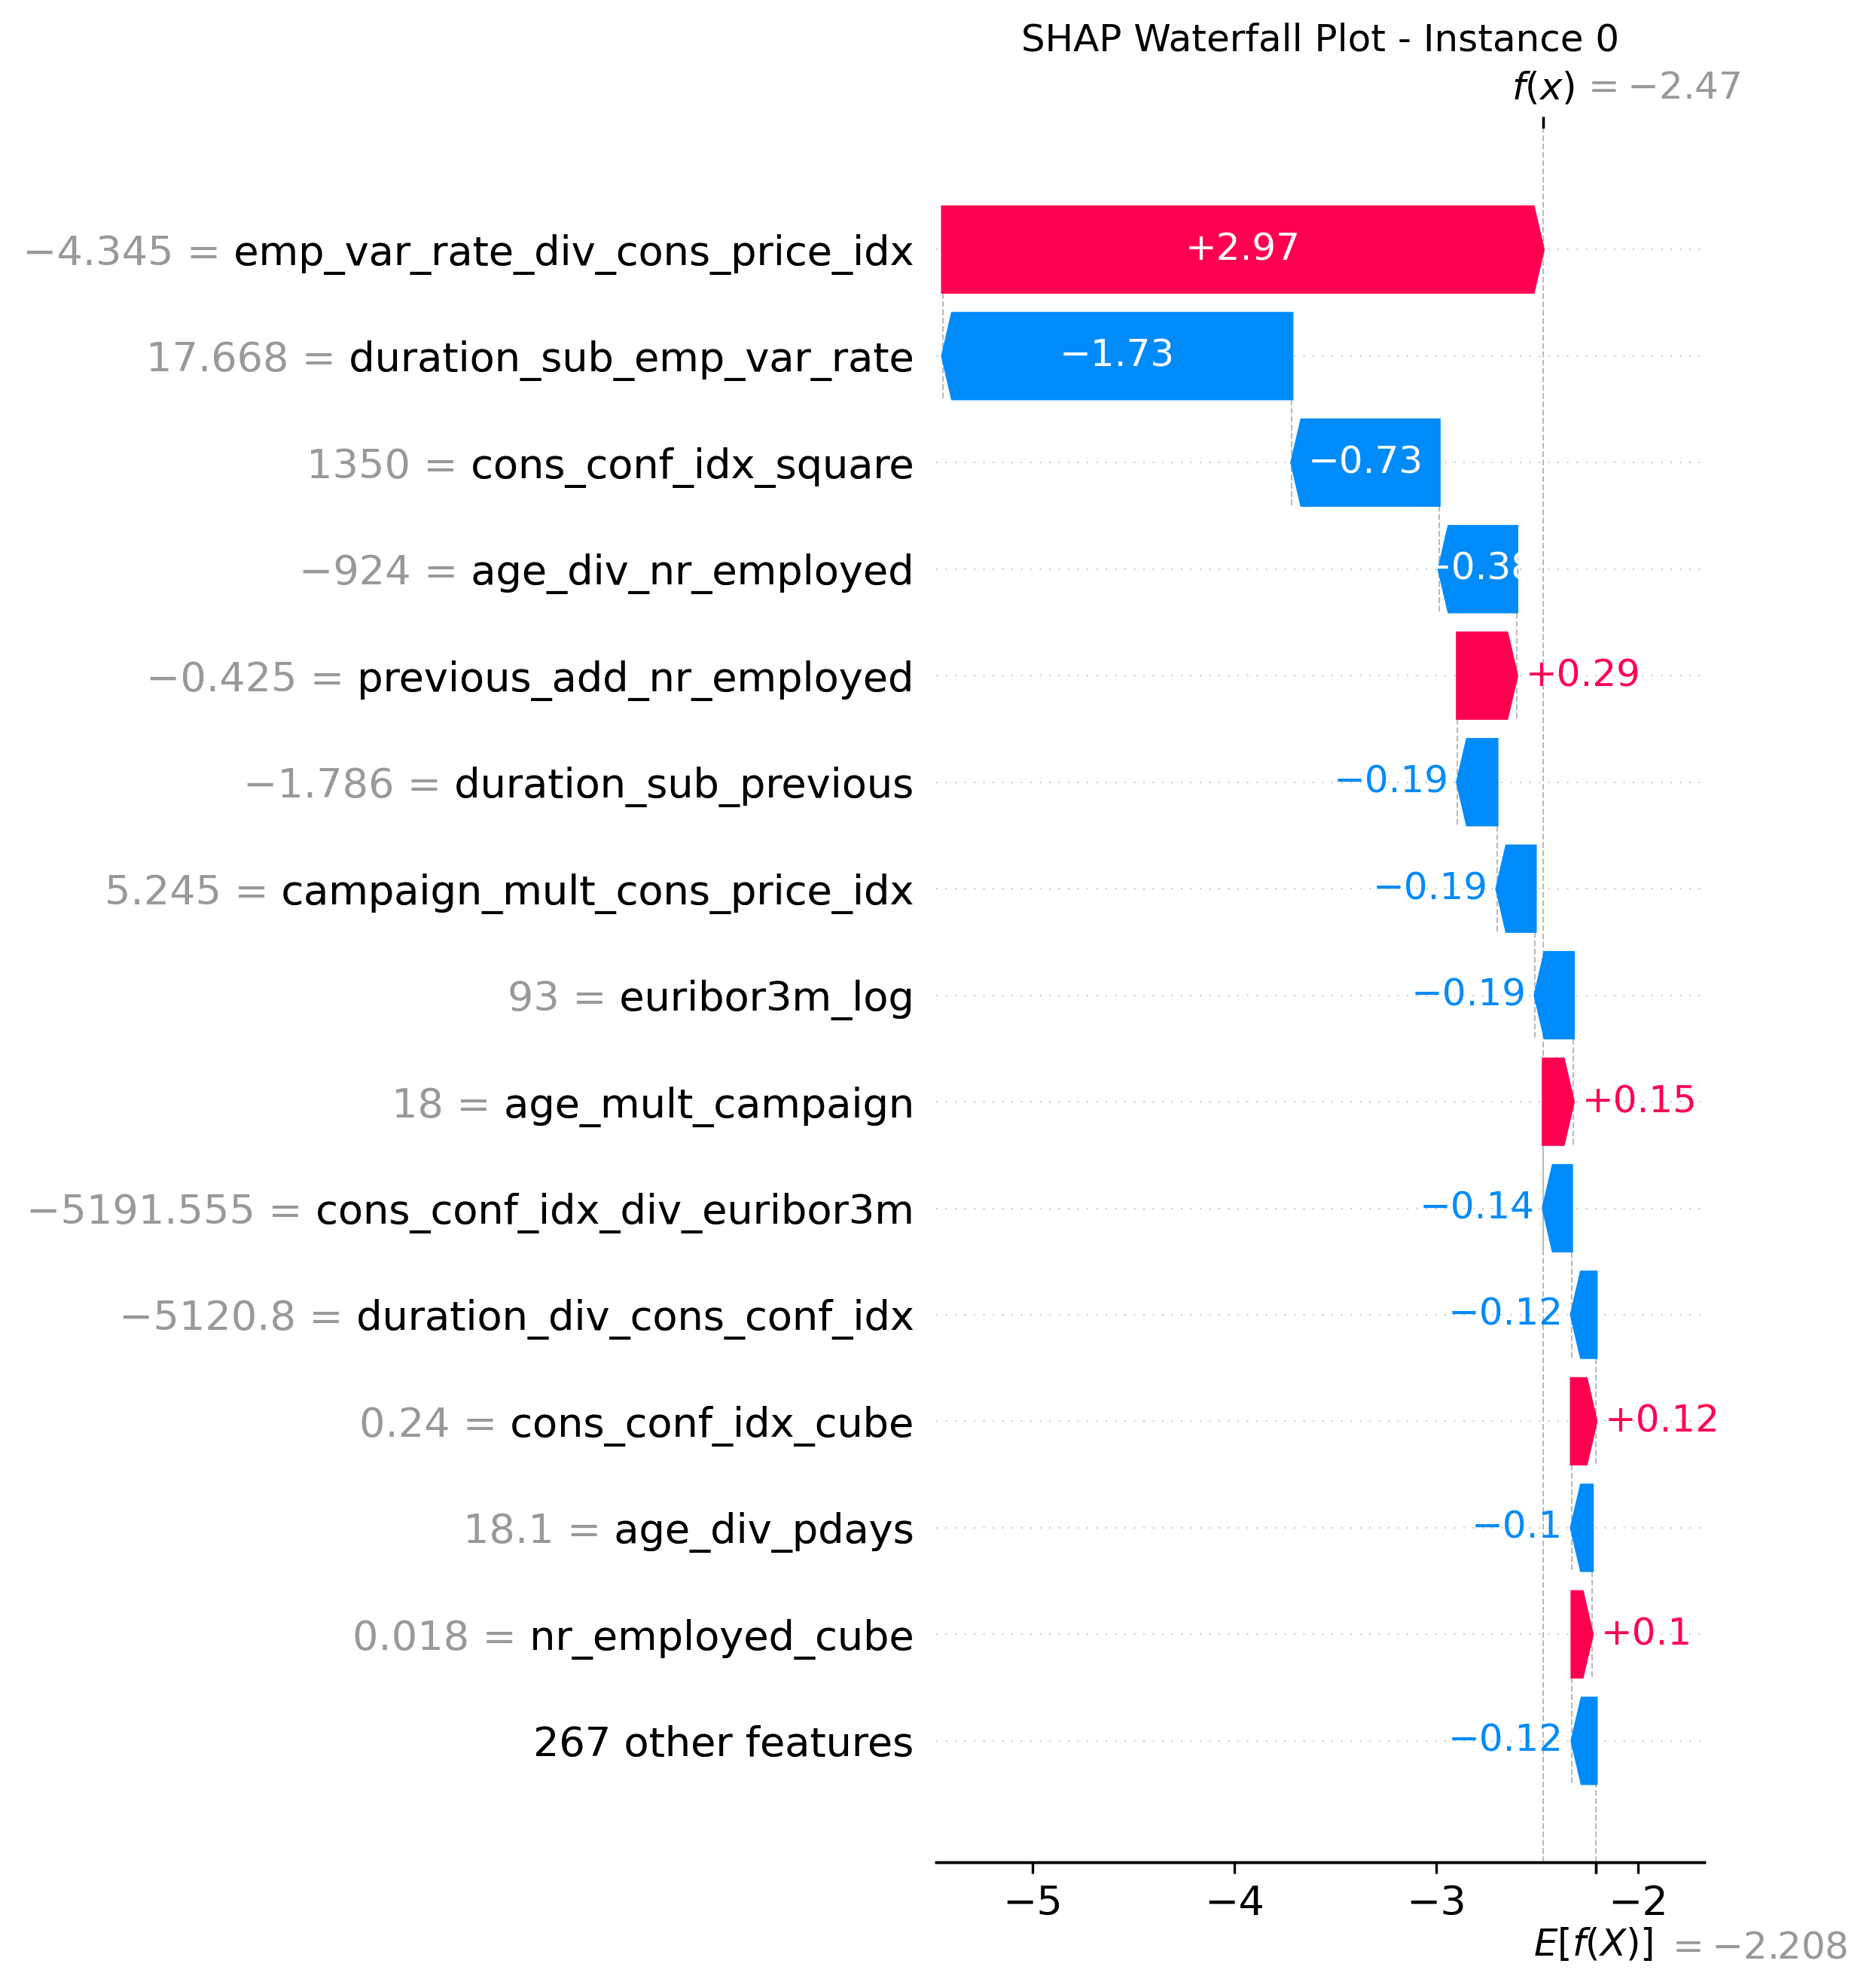

In [35]:
# Generate waterfall plot for the prediction
print("\n📊 Generating SHAP Waterfall Plot...")
feature_selector.plot_shap_waterfall(instance_idx=0, use_test=True)

# Display the saved plot
from IPython.display import Image, display
display(Image(filename='shap_waterfall_instance_0.png'))

---
## 10.2 📊 Feature Insight Analysis (NEW)

Feature Insight Analysis provides SparkBeyond-style discovery of feature conditions that have high **Lift** (how much better than baseline), **Support** (coverage), and **RIG** (Relative Information Gain).

This helps identify:
- Which feature values are most predictive of the target
- Microsegments (combinations of features) that perform even better
- Optimal trade-offs between lift and support

In [ ]:
from backend.core.features.insight_analyzer import FeatureInsightAnalyzer, quick_insight_analysis

print("📊 FEATURE INSIGHT ANALYSIS")
print("=" * 60)
print("\nAnalyzing features for lift, support, and RIG...")

# Initialize the analyzer
insight_analyzer = FeatureInsightAnalyzer(
    df=df_with_features,  # Use original data (not transformed)
    problem=problem,
    schema_checks=schema_checker,
    n_bins=10,          # Number of bins for numeric features
    min_support=0.01,   # Minimum 1% support
    min_lift=1.1        # Minimum 10% lift over baseline
)

# Run analysis
result = insight_analyzer.get_analysis_result(discover_microsegments=True)

print(f"\n📈 Analysis Summary:")
print(f"  Target Class: {result.target_class}")
print(f"  Baseline Rate: {result.baseline_rate*100:.2f}%")
print(f"  Total Records: {result.total_count:,}")
print(f"  Total Insights Found: {result.summary['total_insights']}")
print(f"  Microsegments Found: {result.summary['total_microsegments']}")

📊 FEATURE INSIGHT ANALYSIS

Analyzing features for lift, support, and RIG...

📈 Analysis Summary:
  Target Class: yes
  Baseline Rate: 11.27%
  Total Records: 41,188
  Total Insights Found: 62
  Microsegments Found: 8


In [37]:
result

InsightAnalysisResult(insights=[FeatureInsight(feature_name='poutcome', condition="poutcome = 'success'", condition_type='categorical', target_class='yes', lift=5.7798917547781095, support=0.033334951927745944, support_count=1373, rig=np.float64(0.082315850627339), class_rate=0.651128914785142, baseline_rate=0.11265417111780131, description=None, group='Categorical Features', source='poutcome'), FeatureInsight(feature_name='pdays', condition='pdays < 999.000', condition_type='numeric_threshold', target_class='yes', lift=5.66586946625697, support=0.036782558026609694, support_count=1515, rig=np.float64(0.08758862943154219), class_rate=0.6382838283828383, baseline_rate=0.11265417111780131, description=None, group='Numeric Features', source='pdays'), FeatureInsight(feature_name='month', condition="month = 'mar'", condition_type='categorical', target_class='yes', lift=4.487135278514589, support=0.013256288239292998, support_count=546, rig=np.float64(0.018084495734245754), class_rate=0.5054

In [38]:
# Display top insights
print("\n🎯 TOP 20 FEATURE INSIGHTS (Sorted by Lift):")
print("-" * 70)

insights_df = insight_analyzer.to_dataframe(top_n=20)
display_cols = ['Condition', 'Lift', 'Support', 'Support_Count', 'RIG', 'Class_Rate']
print(insights_df[display_cols].to_string(index=False))


🎯 TOP 20 FEATURE INSIGHTS (Sorted by Lift):
----------------------------------------------------------------------
              Condition  Lift Support Support_Count   RIG Class_Rate
   poutcome = 'success' x5.78    3.3%         1,373 0.082      65.1%
        pdays < 999.000 x5.67    3.7%         1,515 0.088      63.8%
          month = 'mar' x4.49    1.3%           546 0.018      50.5%
 nr_employed < 5076.200 x4.34    8.0%         3,301 0.115      48.9%
      euribor3m < 0.908 x4.10    9.1%         3,741 0.116      46.2%
          month = 'sep' x3.99    1.4%           570 0.014      44.9%
    duration >= 528.000 x3.96   10.9%         4,478 0.132      44.6%
 nr_employed < 5099.100 x3.95   12.1%         4,964 0.150      44.5%
          month = 'oct' x3.89    1.7%           718 0.017      43.9%
cons_price_idx < 92.893 x3.57    6.0%         2,483 0.052      40.2%
  emp_var_rate < -1.800 x3.47    7.1%         2,906 0.058      39.1%
      euribor3m < 1.291 x2.92   18.4%         7,572 0.11

In [39]:
# Display microsegments (feature combinations)
print("\n🔗 TOP MICROSEGMENTS (Feature Combinations):")
print("-" * 70)

if result.microsegments:
    for i, micro in enumerate(result.microsegments[:10], 1):
        print(f"\n{i}. {micro.name}")
        print(f"   Lift: x{micro.lift:.2f} | Support: {micro.support*100:.1f}% ({micro.support_count:,}) | RIG: {micro.rig:.3f}")
        print(f"   Class Rate: {micro.class_rate*100:.1f}% vs Baseline: {micro.baseline_rate*100:.1f}%")
else:
    print("No microsegments found that improve over individual features.")


🔗 TOP MICROSEGMENTS (Feature Combinations):
----------------------------------------------------------------------

1. poutcome = 'success' AND nr_employed < 5076.200
   Lift: x6.68 | Support: 2.2% (904) | RIG: 0.072
   Class Rate: 75.2% vs Baseline: 11.3%

2. nr_employed < 5076.200 AND duration >= 528.000
   Lift: x6.51 | Support: 1.0% (417) | RIG: 0.031
   Class Rate: 73.4% vs Baseline: 11.3%

3. pdays < 999.000 AND nr_employed < 5076.200
   Lift: x6.48 | Support: 2.5% (1,013) | RIG: 0.076
   Class Rate: 73.1% vs Baseline: 11.3%

4. poutcome = 'success' AND euribor3m < 0.908
   Lift: x6.48 | Support: 2.3% (929) | RIG: 0.070
   Class Rate: 73.0% vs Baseline: 11.3%

5. poutcome = 'success' AND nr_employed < 5099.100
   Lift: x6.39 | Support: 2.7% (1,117) | RIG: 0.082
   Class Rate: 72.0% vs Baseline: 11.3%

6. pdays < 999.000 AND euribor3m < 0.908
   Lift: x6.34 | Support: 2.5% (1,034) | RIG: 0.075
   Class Rate: 71.5% vs Baseline: 11.3%

7. duration >= 528.000 AND nr_employed < 5099.


📊 Generating Lift vs Support Scatter Plot...
Lift-Support scatter plot saved to 'insight_lift_support.png'


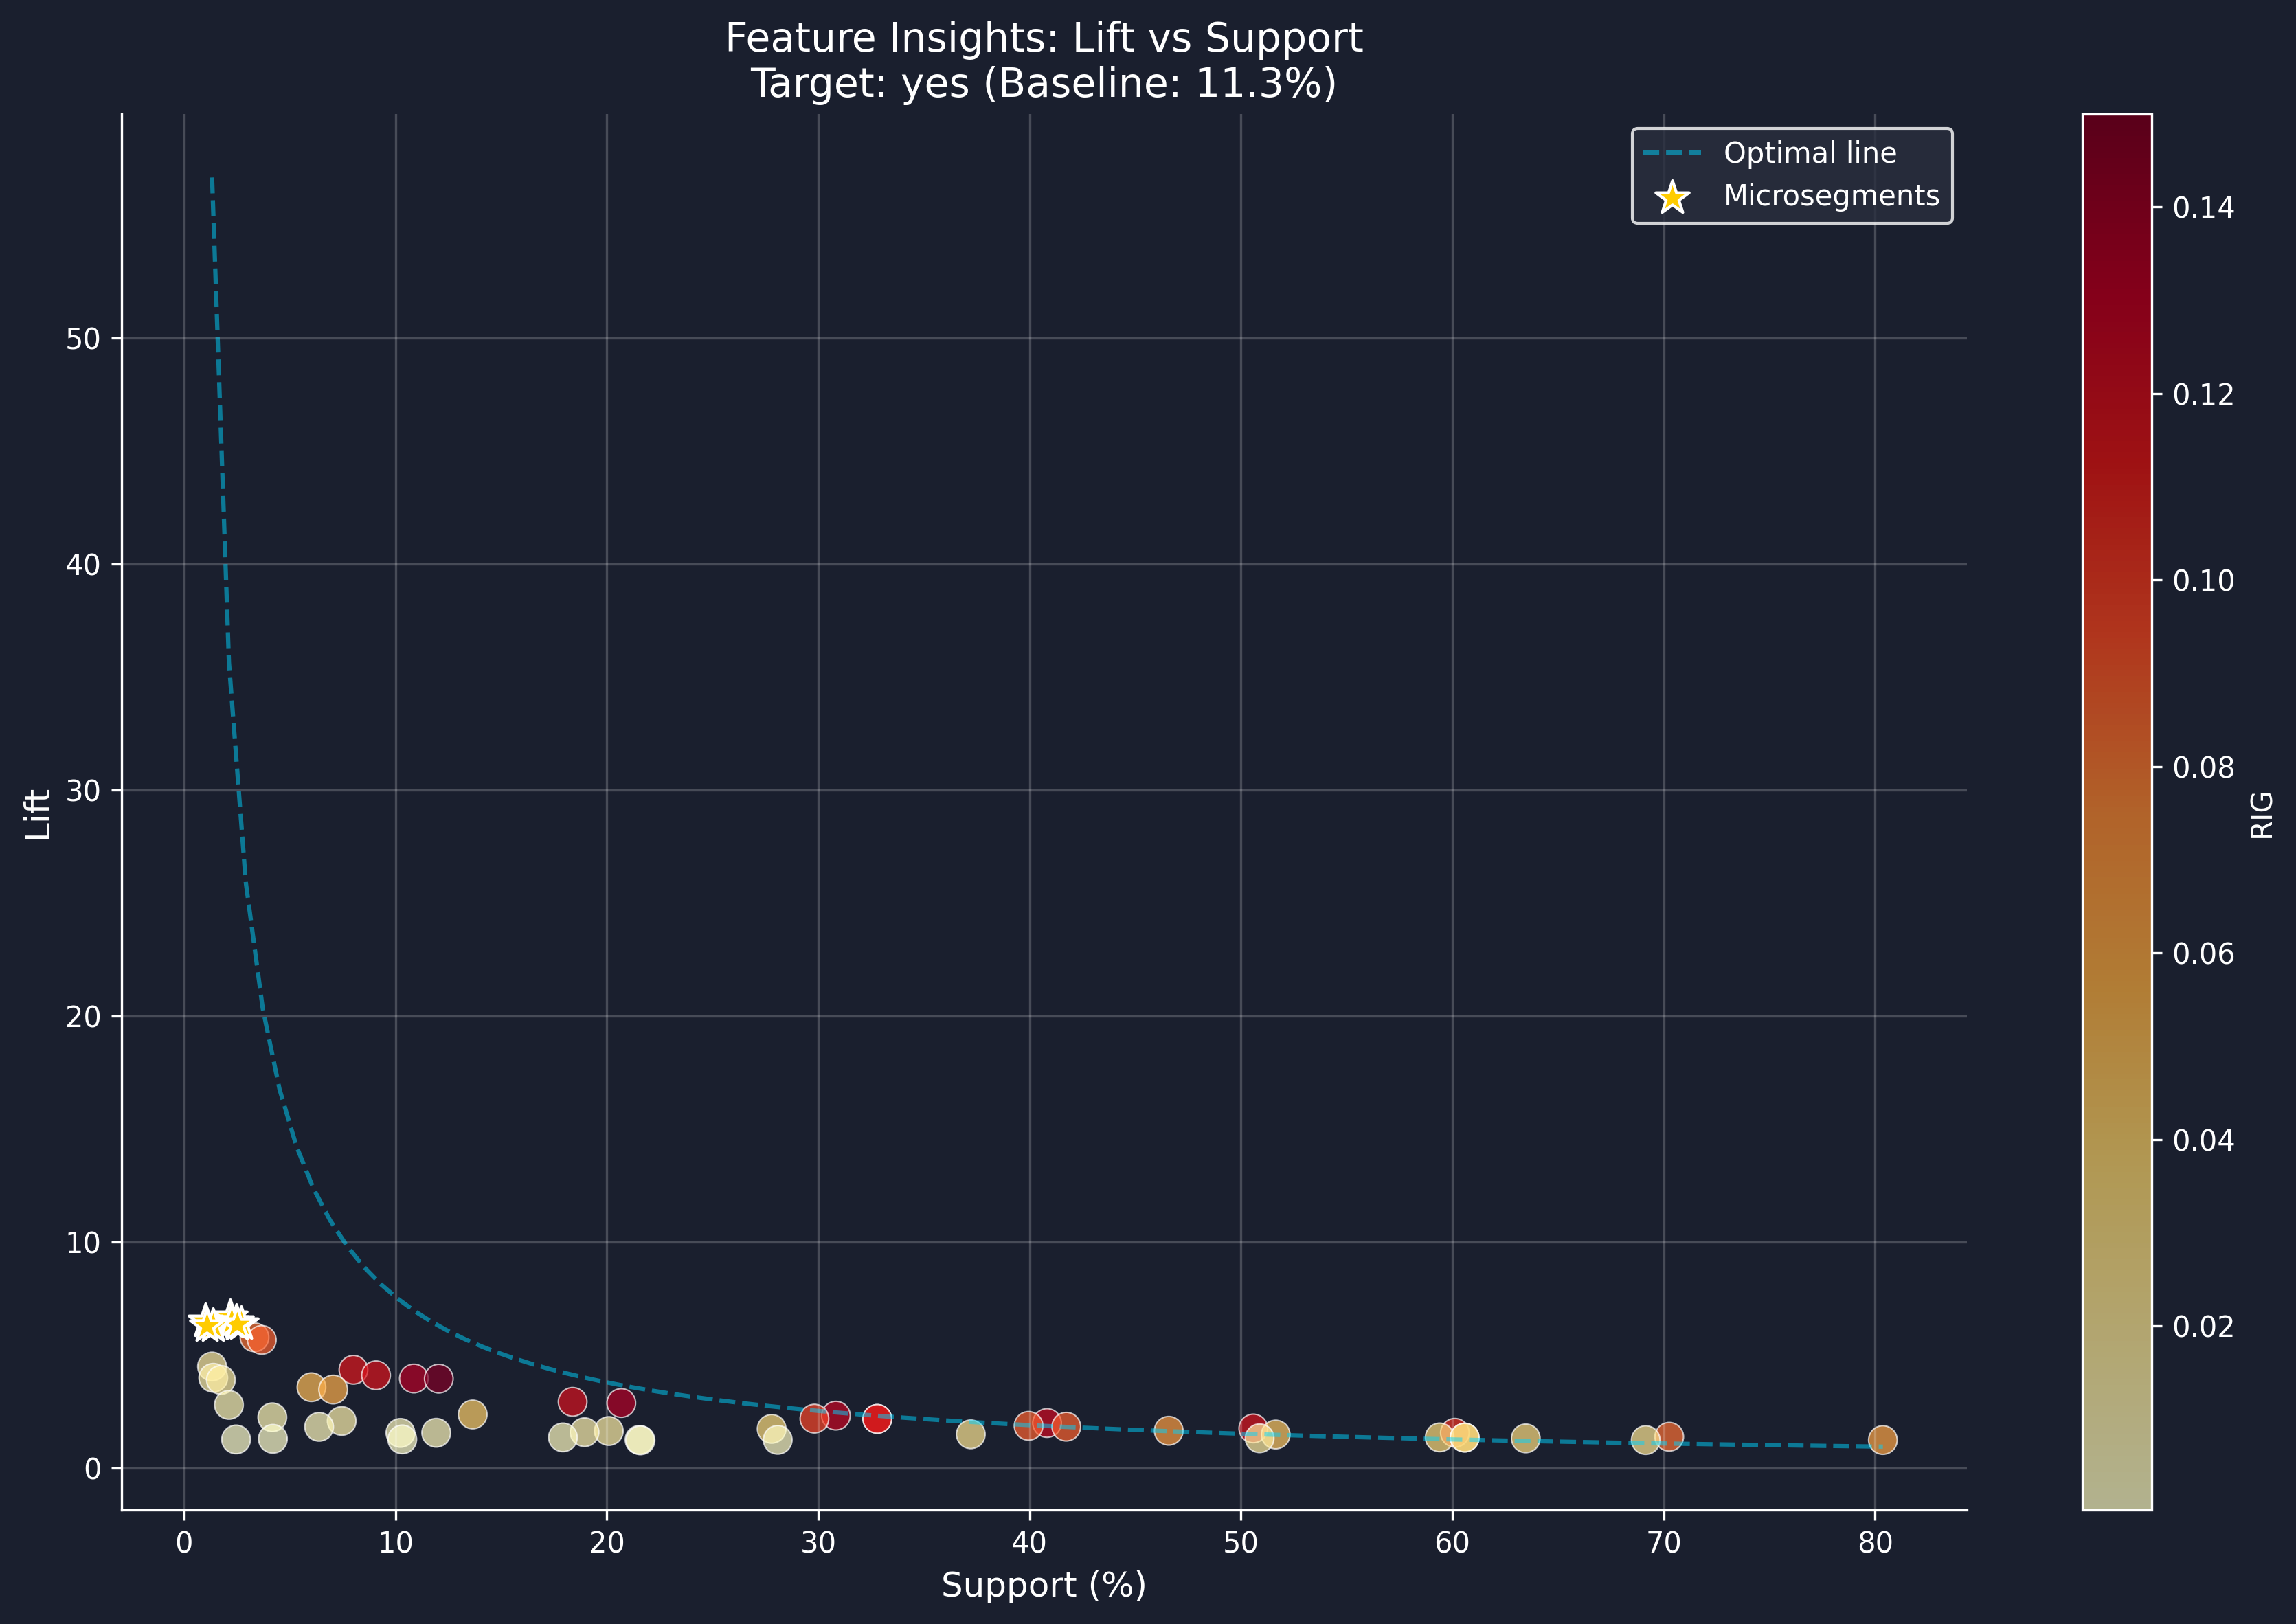

In [40]:
# Generate Lift vs Support scatter plot (like SparkBeyond UI)
print("\n📊 Generating Lift vs Support Scatter Plot...")
insight_analyzer.plot_lift_support_scatter(
    top_n=50,
    highlight_microsegments=True,
    save_path='insight_lift_support.png'
)

# Display the plot
from IPython.display import Image, display
display(Image(filename='insight_lift_support.png'))


📊 Generating Top Insights Bar Chart...
Top insights plot saved to 'insight_top_features.png'


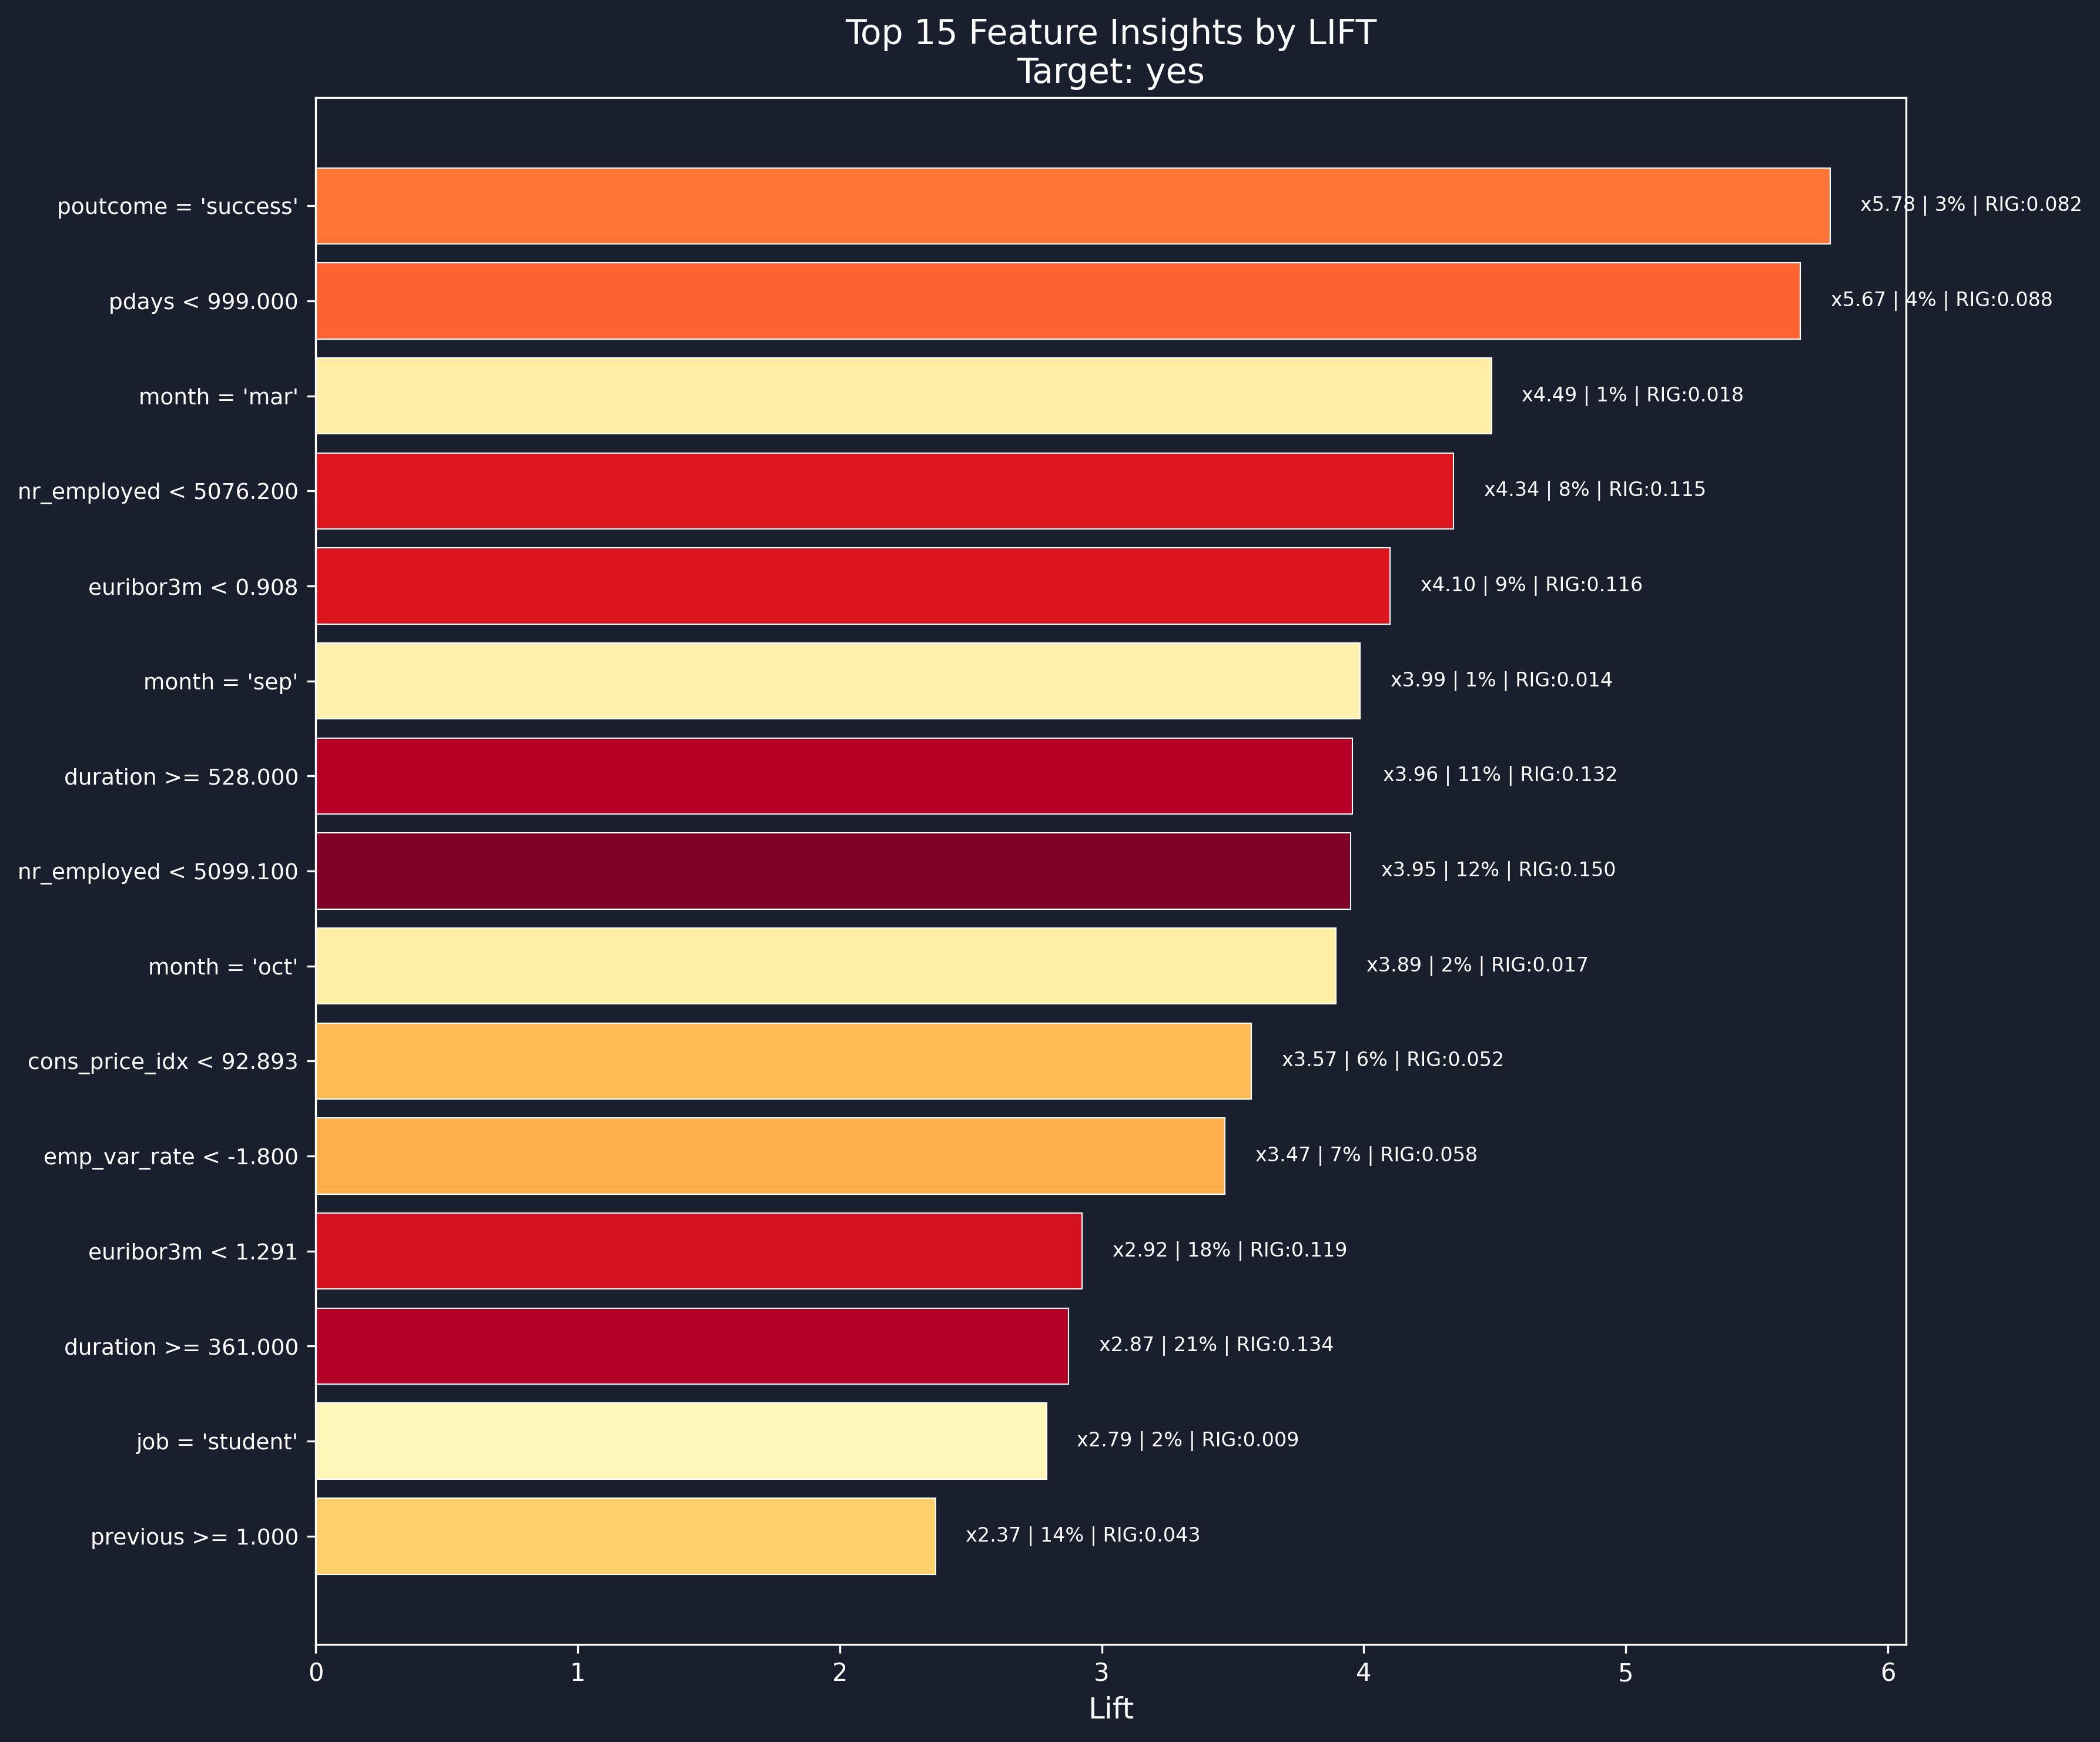

In [41]:
# Generate top insights bar chart
print("\n📊 Generating Top Insights Bar Chart...")
insight_analyzer.plot_top_insights(
    top_n=15,
    metric='lift',
    save_path='insight_top_features.png'
)

# Display the plot
display(Image(filename='insight_top_features.png'))

In [42]:
# You can also use the quick function for rapid analysis
# insights_df, result = quick_insight_analysis(df, problem, schema_checker, top_n=20, plot=True)

# Or access insights through FeatureSelector after training
# insight_result = feature_selector.get_insight_analysis(schema_checker, plot=True)

print("\n✅ Feature Insight Analysis complete!")


✅ Feature Insight Analysis complete!


---
## 11. 🤖 LightAutoML (NEW)

The `AutoMLRunner` provides automated machine learning using LightAutoML,
which automatically tries multiple algorithms and finds the best model.

In [ ]:
from backend.core.models.evalml_runner import AutoMLRunner, quick_automl

print("🤖 LIGHTAUTOML SEARCH")
print("=" * 50)
print("\nThis may take a few minutes...\n")

# Initialize AutoML runner
automl_runner = AutoMLRunner(
    spark=spark,
    problem=problem,
    max_rows_for_pandas=50000,  # Sample for faster demo
    verbose=True
)

# Run AutoML search: Quick Mode
automl_result = automl_runner.run_automl(
    spark_df=df_with_features,
    timeout=120,  # 2 minutes for demo
    cpu_limit=4,
    quick_mode=True
)

# # Run AutoML search: Full Mode
# automl_result = automl_runner.run_automl(
#     spark_df=df_with_features,
#     timeout=600,  # 2 minutes for demo
#     cpu_limit=4,
# )

print("\n✅ AutoML search complete!")

🤖 LIGHTAUTOML SEARCH

This may take a few minutes...

[01:22:27] Stdout logging level is INFO.
[01:22:27] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[01:22:27] Task: binary

[01:22:27] Start automl preset with listed constraints:
[01:22:27] - time: 120.00 seconds
[01:22:27] - CPU: 4 cores
[01:22:27] - memory: 16 GB

[01:22:27] Train data shape: (41188, 249)

[01:22:34] Layer 1 train process start. Time left 113.09 secs
[01:22:37] Selector_LightGBM fitting and predicting completed
[01:22:39] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[01:22:49] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = 0.9492107509538708
[01:22:49] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[01:22:49] Time left 98.09 secs

[01:22:49] Layer 1 training completed.

[01:22:49] Automl preset training completed in 21.92 seconds

[01:22:49] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_

Could not extract feature importance: Per-column arrays must each be 1-dimensional



✅ AutoML search complete!


In [44]:
# Display AutoML results
print("\n📊 AUTOML RESULTS:")
print("-" * 40)
print(f"  Best Score: {automl_result.best_score:.4f}")
print(f"  Problem Type: {automl_result.problem_type}")
print(f"  Metric: {automl_result.metric}")
print(f"  Search Time: {automl_result.search_time:.1f}s")

if automl_result.model_summary:
    print(f"\n  Models in ensemble: {automl_result.model_summary.get('n_models', 0)}")
    print(f"  Levels: {automl_result.model_summary.get('levels', 0)}")


📊 AUTOML RESULTS:
----------------------------------------
  Best Score: 0.9492
  Problem Type: binary
  Metric: auc
  Search Time: 25.6s

  Models in ensemble: 1
  Levels: 1


In [45]:
# AutoML feature importance
if automl_result.feature_importance is not None:
    print("\n🎯 AUTOML TOP FEATURES:")
    print("-" * 40)
    print(automl_result.feature_importance.head(15).to_string(index=False))

In [46]:
# Evaluate AutoML on test data
print("\n📊 AUTOML EVALUATION ON TEST DATA:")
print("-" * 40)

automl_metrics = automl_runner.evaluate(df_with_features)
for metric, value in automl_metrics.items():
    print(f"  {metric}: {value:.4f}")


📊 AUTOML EVALUATION ON TEST DATA:
----------------------------------------
  accuracy: 0.8873
  precision: 0.7874
  recall: 0.8873
  f1: 0.8344
  auc: 0.9661


---
## 12. 🔬 Model Comparison (NEW)

The `ModelComparison` framework tracks experiments and measures the impact
of feature engineering and model selection.

In [ ]:
from backend.core.models.model_comparison import ModelComparison

# Initialize comparison framework
comparison = ModelComparison(primary_metric='accuracy')

# Add baseline results
for result in all_results:
    comparison.add_baseline_result(result)

# Add XGBoost result
comparison.add_experiment(
    name="XGBoost + Engineered Features",
    model_name="XGBoost",
    feature_set="engineered",
    metrics=test_metrics,
    training_time=0
)

# Add AutoML result
comparison.add_experiment(
    name="LightAutoML",
    model_name="LightAutoML Ensemble",
    feature_set="engineered",
    metrics=automl_metrics,
    training_time=automl_result.search_time
)

print("✅ Added all experiments to comparison framework")

✅ Added all experiments to comparison framework


In [48]:
# Get comparison results
comparison_result = comparison.get_comparison()

print("\n🔬 MODEL COMPARISON:")
print("=" * 70)
print(comparison_result.comparison_table.to_string())


🔬 MODEL COMPARISON:
  experiment_id                                           name                               model feature_set  training_time num_features  accuracy        f1  precision    recall   auc_roc  f1_score       auc
3       exp_004                  XGBoost + Engineered Features                             XGBoost  engineered       0.000000         None  0.919133       NaN   0.914846  0.919133  0.950783  0.916618       NaN
1       exp_002                       Baseline - Decision Tree                       Decision Tree    original       9.437551         None  0.915723  0.914687   0.913770  0.915723  0.931197       NaN       NaN
2       exp_003                 Baseline - Logistic Regression                 Logistic Regression    original      10.344791         None  0.915357  0.910349   0.907808  0.915357  0.941445       NaN       NaN
0       exp_001  Baseline - Naive Baseline (Majority Class: 0)  Naive Baseline (Majority Class: 0)    original      10.061031         None 

In [49]:
# Display improvements
print("\n📈 IMPACT ANALYSIS:")
print("-" * 50)

if comparison_result.improvements:
    for impact_name, impact_data in comparison_result.improvements.items():
        print(f"\n{impact_name.replace('_', ' ').title()}:")
        print(f"  Absolute Improvement: {impact_data.get('absolute_improvement', 0):.4f}")
        print(f"  Percentage Improvement: {impact_data.get('percentage_improvement', 0):.2f}%")
        print(f"  Best Model: {impact_data.get('best_model', 'N/A')}")


📈 IMPACT ANALYSIS:
--------------------------------------------------

Feature Engineering:
  Absolute Improvement: 0.0034
  Percentage Improvement: 0.37%
  Best Model: N/A

Vs Baseline:
  Absolute Improvement: 0.0270
  Percentage Improvement: 3.03%
  Best Model: XGBoost

Model Selection Original:
  Absolute Improvement: 0.0236
  Percentage Improvement: 2.65%
  Best Model: Decision Tree

Model Selection Engineered:
  Absolute Improvement: 0.0318
  Percentage Improvement: 3.58%
  Best Model: XGBoost


In [50]:
# Best model
print("\n🏆 BEST MODEL:")
print("-" * 50)
best = comparison_result.best_experiment
print(f"  Name: {best.name}")
print(f"  Model: {best.model_name}")
print(f"  Feature Set: {best.feature_set}")
print(f"  {comparison.primary_metric.title()}: {best.metrics.get(comparison.primary_metric, 0):.4f}")


🏆 BEST MODEL:
--------------------------------------------------
  Name: XGBoost + Engineered Features
  Model: XGBoost
  Feature Set: engineered
  Accuracy: 0.9191


---
## 📝 Summary

This notebook demonstrated all the new features in Spark Tune:

| Feature | Module | Description |
|---------|--------|-------------|
| Data Quality Checking | `core.profiling.data_quality` | PySpark-native quality analysis |
| YData Profiling | `core.profiling.ydata_profiler` | Comprehensive data profiling |
| Time Series Detection | `core.utils.time_series_detector` | Automatic temporal pattern detection |
| Enhanced Preprocessing | `core.features.preprocessing_enhanced` | Missing values, outliers, scaling |
| Baseline Models | `core.models.baseline_models` | Simple model comparison |
| **SHAP Analysis** | `core.features.feature_selector` | Model interpretability with SHAP |
| **Feature Insights** | `core.features.insight_analyzer` | Lift, Support, RIG analysis (SparkBeyond-style) |
| LightAutoML | `core.models.evalml_runner` | Automated machine learning |
| Model Comparison | `core.models.model_comparison` | Impact analysis framework |

### Key Metrics in Feature Insight Analysis:
- **Lift**: How much better a feature condition performs vs. baseline (e.g., x3.09 = 3x better)
- **Support**: Percentage of data covered by the condition (e.g., 25% = 10,234 records)
- **RIG**: Relative Information Gain - how much information the feature provides about the target

In [52]:
# Cleanup
spark.stop()
print("\n✅ Spark session stopped. Demo complete!")


✅ Spark session stopped. Demo complete!
